# Simple Linear Regression Portfolio Project: TV Advertising vs Sales

A hands-on project exploring the impact of TV advertising on product sales using Simple Linear Regression, with visualizations, gradient descent, and Scikit-Learn.

## Background

This portfolio project simulates a real-world data science consulting scenario. As statistical consultants, we are hired to investigate the relationship between **TV advertising budgets** and **product sales** across 200 different markets.

The dataset provides observations on the **TV advertising expenditures** and corresponding **sales figures** for a single product. The client has **full control over the TV advertising budget**, and the goal is to determine whether a change in spending can **predict or influence** sales performance.

<div class="alert alert-info" style="margin: 20px">
  While more complex models (e.g., KNN, Decision Trees, or ensemble methods) may be considered in other contexts, this project focuses on <strong>Simple Linear Regression</strong> due to its <strong>interpretability, foundational importance, and relevance in statistical learning</strong>.
</div>

---

## Project Objective & Key Questions

This project aims to investigate the relationship between **TV advertising spending** and **product sales**, and to build a reliable model that supports business decision-making.

### Project Objectives

- Determine whether a **linear relationship** exists between **TV advertising spending** and **sales**.
- Develop a **Simple Linear Regression model** to quantify the association.
- Evaluate the model's fit and reliability using appropriate metrics.
- Provide **business-oriented recommendations** on advertising strategies based on data analysis.
- Apply and compare **manual implementation**, **analytical solutions (OLS)**, and **Scikit-Learn's built-in LinearRegression model**.

### Important Questions We Seek to Address

- How does TV advertising affect product sales?
- Can we **quantify the return** on every additional dollar spent on TV?
- Is the relationship between TV spend and sales **statistically significant**?
- How accurate is our model in predicting future sales?
- To what extent can we rely on TV advertising alone for sales forecasting?
- What is the **expected sales level** if no advertising budget is allocated?

---

## Learning Outcomes

By completing this project, the following skills and concepts will be demonstrated:

- Deep understanding of **Simple Linear Regression**, including:
  - Analytical approach using **Ordinary Least Squares (OLS)**
  - Manual parameter estimation using **Gradient Descent**
  - Cost function visualization and convergence diagnostics
- Application of industry-standard tools and libraries:
  - **Pandas** and **NumPy** for data handling and numerical computation
  - **Matplotlib** and **Seaborn** for data visualization and trend analysis
  - **Scikit-Learn** for building and evaluating regression models
- Model interpretation and evaluation:
  - **Coefficient and intercept analysis**
  - **R² Score**, **Mean Squared Error (MSE)**, and residual diagnostics
  - Understanding of **feature scaling** and its effect on gradient descent
- Business communication:
  - Translate technical results into clear, data-driven insights for strategic decision-making

---

# 1. Import Modules

In [16]:
import sys
import os

# Add project root to sys.path (one level up from "notebooks/")
sys.path.append(os.path.abspath(".."))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import t
from spend_sale_lib.IQR import plot_iqr_outliers_with_boxplot
from spend_sale_lib.OLS import Simple_OLS
from spend_sale_lib.Gradient_Descend import simple_gradient_descent
from scipy import stats

from sklearn.linear_model import LinearRegression

---

# 2. Load Dataset

| Feature        | Description                                                                                   |
|----------------|-----------------------------------------------------------------------------------------------|
| `Unnamed: 0`   | Additional index column. ✅ Confirmed with client that it can be safely **dropped**. (Discussed in Section 3(Histogram) and Section 4(Feature selection) )          |
| `TV`           | TV advertising spending. Unit: **thousands of dollars**.                                      |
| `Sales`        | Product sales quantity at the corresponding advertising budget. Unit: **thousands of units** *(not dollars)*. |

In [17]:
df = pd.read_csv('../data/Advertising_simple.csv')
df

,Unnamed: 0,TV,Sales
0,1,230.1,22.1
1,2,44.5,10.4
2,3,17.2,9.3
3,4,151.5,18.5
4,5,180.8,12.9
...,...,...,...
195,196,38.2,7.6
196,197,94.2,9.7
197,198,177.0,12.8
198,199,283.6,25.5


---

# 3. Data Visualization

- A [histogram](https://www.atlassian.com/data/charts/histogram-complete-guide#:~:text=A%20histogram%20is%20a%20chart,value%20within%20the%20corresponding%20bin.) is a visual representation of the distribution of quantitative data.
- According to [Statistic Canada](https://www150.statcan.gc.ca/n1/edu/power-pouvoir/ch9/histo/5214822-eng.htm):" *The histogram is a popular graphing tool. It is used to summarize discrete or continuous data that are measured on an interval scale. It is often used to illustrate the **major features of the distribution of the data** in a convenient form. It is also useful when dealing with large data sets (greater than 100 observations). It can help detect any **unusual observations (outliers)** or any gaps in the data.*"
- There is additional resource to help understanding histogram that provided from [wikipedia](https://en.wikipedia.org/wiki/Histogram). It also explain the how to select number of bins and width.

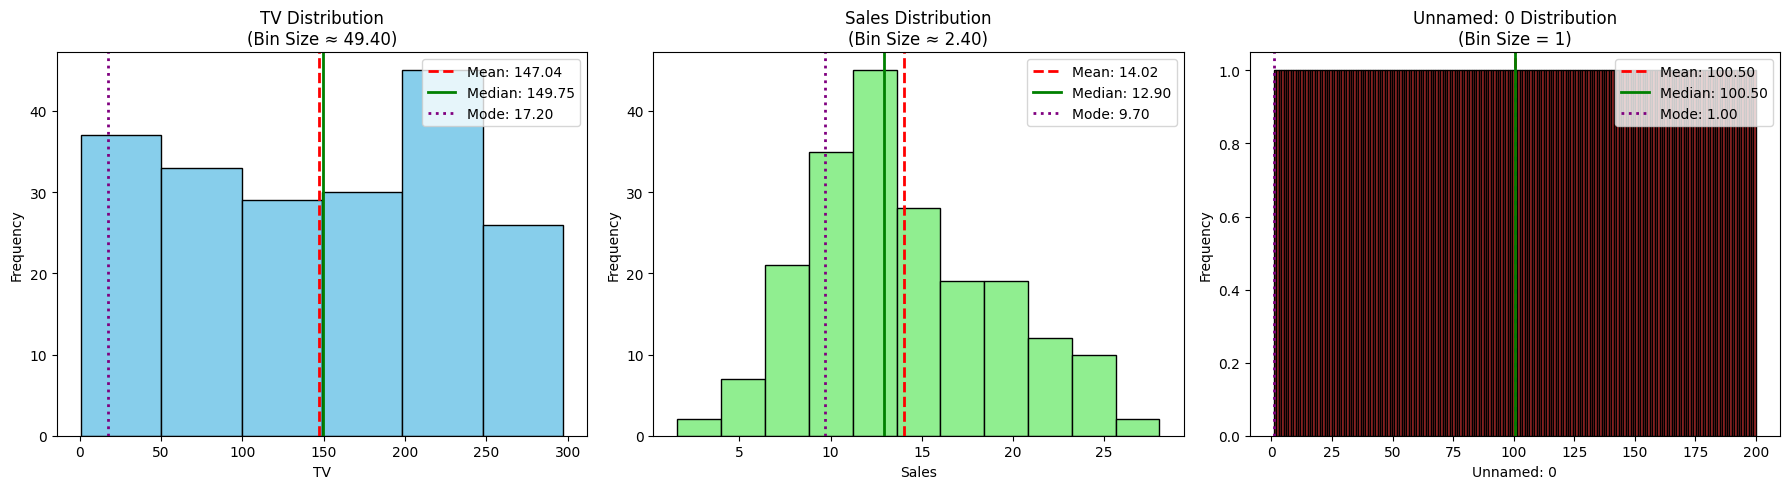

In [18]:
# Freedman–Diaconis rule function (returns bin edges and bin size)
def compute_bin_edges(data):
    q25, q75 = np.percentile(data, [25, 75])
    iqr = q75 - q25
    bin_width = 2 * iqr / (len(data) ** (1/3))
    if bin_width == 0:  # fallback
        bin_width = (data.max() - data.min()) / 10
    bins = np.arange(data.min(), data.max() + bin_width, bin_width)
    return bins, bin_width

# 计算bin
tv_bins, tv_bin_width = compute_bin_edges(df['TV'])
sales_bins, sales_bin_width = compute_bin_edges(df['Sales'])

# 计算mean, median, mode
tv_mean = df['TV'].mean()
tv_median = df['TV'].median()
tv_mode = stats.mode(df['TV'], keepdims=True)[0][0]

sales_mean = df['Sales'].mean()
sales_median = df['Sales'].median()
sales_mode = stats.mode(df['Sales'], keepdims=True)[0][0]

unnamed_mean = df['Unnamed: 0'].mean()
unnamed_median = df['Unnamed: 0'].median()
unnamed_mode = stats.mode(df['Unnamed: 0'], keepdims=True)[0][0]

# 绘图
plt.figure(figsize=(18, 5))

# TV
plt.subplot(1, 3, 1)
plt.hist(df['TV'], bins=tv_bins, color='skyblue', edgecolor='black')
plt.axvline(tv_mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {tv_mean:.2f}')
plt.axvline(tv_median, color='green', linestyle='-', linewidth=2, label=f'Median: {tv_median:.2f}')
plt.axvline(tv_mode, color='purple', linestyle=':', linewidth=2, label=f'Mode: {tv_mode:.2f}')
plt.xlabel("TV")
plt.ylabel("Frequency")
plt.title(f"TV Distribution\n(Bin Size ≈ {tv_bin_width:.2f})")
plt.legend()

# Sales
plt.subplot(1, 3, 2)
plt.hist(df['Sales'], bins=sales_bins, color='lightgreen', edgecolor='black')
plt.axvline(sales_mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {sales_mean:.2f}')
plt.axvline(sales_median, color='green', linestyle='-', linewidth=2, label=f'Median: {sales_median:.2f}')
plt.axvline(sales_mode, color='purple', linestyle=':', linewidth=2, label=f'Mode: {sales_mode:.2f}')
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.title(f"Sales Distribution\n(Bin Size ≈ {sales_bin_width:.2f})")
plt.legend()

# Unnamed: 0
plt.subplot(1, 3, 3)
plt.hist(df['Unnamed: 0'], bins=200, color='brown', edgecolor='black')
plt.axvline(unnamed_mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {unnamed_mean:.2f}')
plt.axvline(unnamed_median, color='green', linestyle='-', linewidth=2, label=f'Median: {unnamed_median:.2f}')
plt.axvline(unnamed_mode, color='purple', linestyle=':', linewidth=2, label=f'Mode: {unnamed_mode:.2f}')
plt.xlabel("Unnamed: 0")
plt.ylabel("Frequency")
plt.title(f"Unnamed: 0 Distribution\n(Bin Size = 1)")
plt.legend()

plt.tight_layout()
plt.show()

### Histogram Interpretation

**TV Distribution (Left)**
- Same as before: 5 bins, each about 49.4 wide.
- Most TV advertising budgets fall between 200–250, showing a common tendency for higher ad spending.
- The distribution remains right-skewed: many markets invest moderately to heavily, but there’s still a fair number with minimal spending.

**Sales Distribution (Middle)**
- Distribution still appears roughly normal, with a slight left skew.
- Peak sales are around 12–14 units, with fewer markets achieving below ~5 or above ~25.
- The bell shape supports assumptions of normality in downstream regression models, which is ideal.

**“Unnamed: 0” Distribution (Right)**
- This plot shows a uniform flat distribution — each value occurs exactly once.
- Bin Size = 1, suggesting each bar corresponds to a unique value (like an index column).
- *Title Unnamed: 0 indicates this is likely the DataFrame’s index column accidentally included in the plot.* Need to confirm with clients for additional information

`Unnamed: 0` :
- It has no predictive power and should be excluded from further modeling.
- Including this in regression would be nonsensical, as it’s just an identifier, not an input variable.
- Confirmed with client that  can be safely **dropped**. 

In [19]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,200.0,100.5000,57.879185,1.0,50.750,100.50,150.250,200.0
TV,200.0,147.0425,85.854236,0.7,74.375,149.75,218.825,296.4
Sales,200.0,14.0225,5.217457,1.6,10.375,12.90,17.400,27.0


In [20]:
# drop feature 'Unnamed:0'
df = df.drop(['Unnamed: 0'], axis=1)
df

,TV,Sales
0,230.1,22.1
1,44.5,10.4
2,17.2,9.3
3,151.5,18.5
4,180.8,12.9
...,...,...
195,38.2,7.6
196,94.2,9.7
197,177.0,12.8
198,283.6,25.5


---

# 4. Check Noise and Denoise

The Interquartile Range (IQR) method was used to detect potential noise in the dataset. [See explanation on Wikipedia](https://en.wikipedia.org/wiki/Interquartile_range).

The Interquartile Range (IQR) is defined as:

$$
\text{IQR} = Q_3 - Q_1
$$

Where:
- \( Q_1 \) = First quartile (25th percentile)
- \( Q_3 \) = Third quartile (75th percentile)

To detect outliers, we use the following bounds:

- **Lower bound**:  
  $$
  \text{Lower} = Q_1 - 1.5 \times \text{IQR}
  $$

- **Upper bound**:  
  $$
  \text{Upper} = Q_3 + 1.5 \times \text{IQR}
  $$

Any data point outside this range is considered a potential outlier.

<div align="center">
  <img src="https://miro.medium.com/v2/resize:fit:1200/1*0MPDTLn8KoLApoFvI0P2vQ.png" alt="IQR" width="700" height="350"/>
</div>

### Interquartile Range Result Interpretation

- After applying the IQR-based filtering, we found **no potential outliers**, indicating that the dataset is clean and free of significant noise.

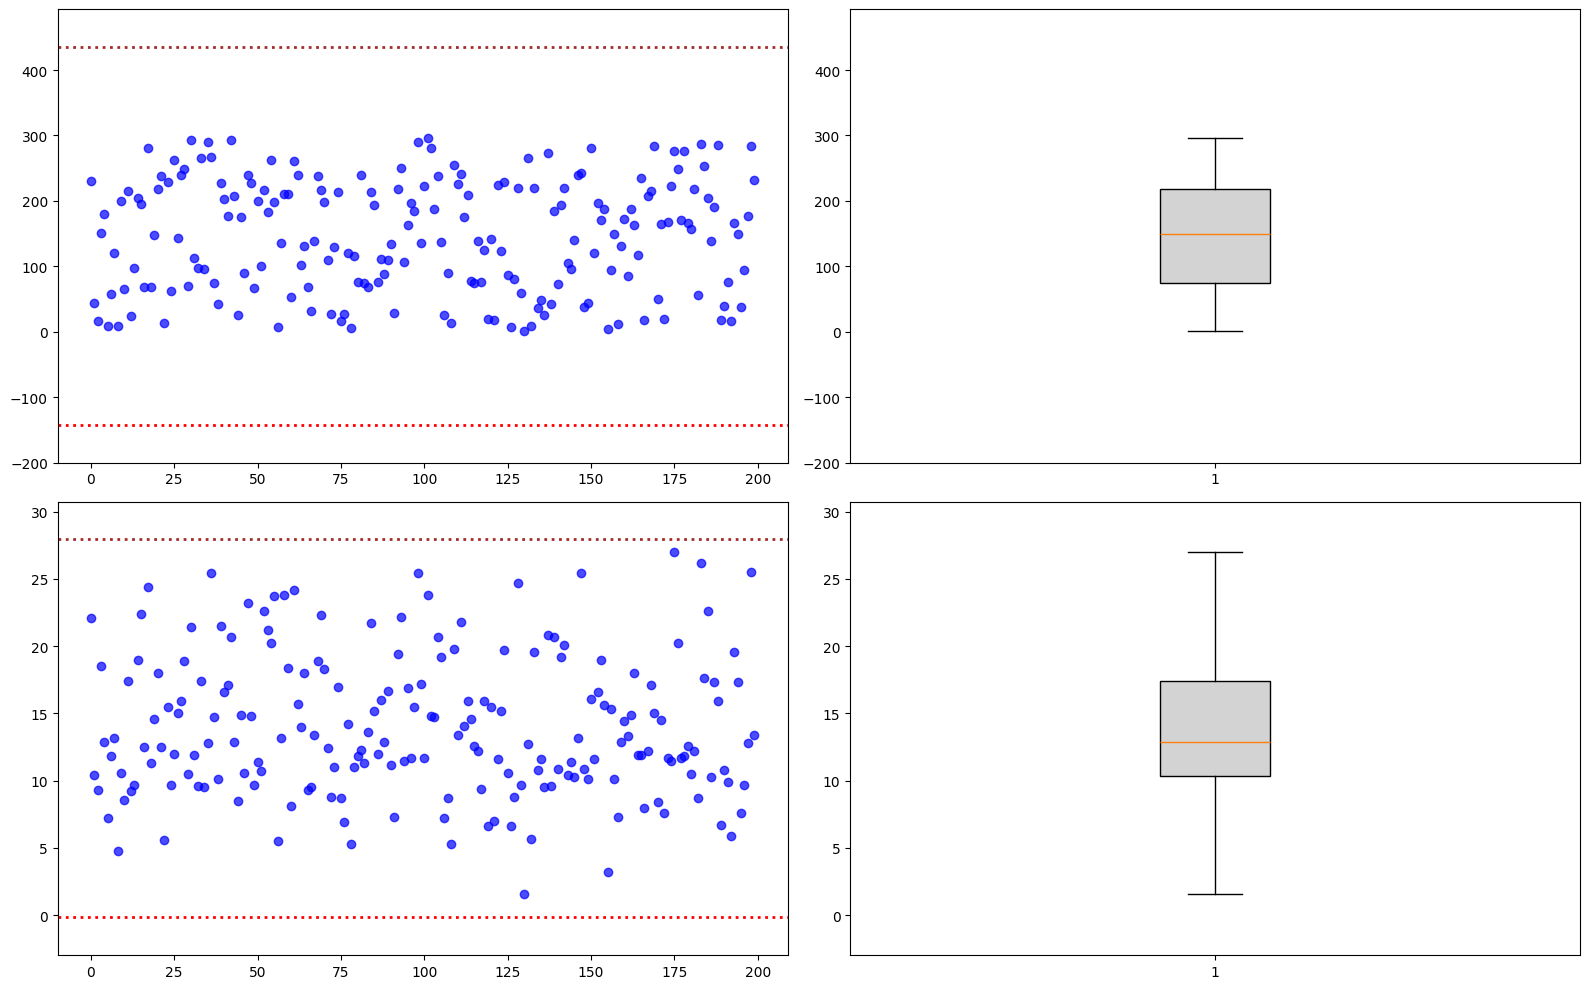

In [21]:
plot_iqr_outliers_with_boxplot(df, figsize=(16, 5))  # all features

---

# 5. TV V.S. Sales Correlation

Before applying linear regression, it’s essential to assess whether a linear relationship exists between the independent variable (TV advertising spend) and the dependent variable (Sales). This can be evaluated using the Pearson correlation coefficient, which measures the strength and direction of a linear association between two variables.

The Pearson correlation coefficient \( r \) between variables \( X \) and \( Y \) is defined as:

$$
r = \frac{\sum_{i=1}^{n} (X_i - \bar{X})(Y_i - \bar{Y})}
         {\sqrt{\sum_{i=1}^{n} (X_i - \bar{X})^2} \sqrt{\sum_{i=1}^{n} (Y_i - \bar{Y})^2}}
$$

where:
- $ X_i, Y_i$ are the individual sample points,
- $\bar{X}$, $\bar{Y}$ are the sample means of $X$ and $Y$,
- $n$ is the number of observations.

<div align="center">
  <img src="https://www.simplypsychology.org/wp-content/uploads/correlation-coefficient.jpg" alt="IQR" width="700" height="350"/>
</div>

**Common References Supporting the 0.7 Threshold**

1.	[Cohen’s Guidelines (1988)](https://academic.oup.com/innovateage/article/3/4/igz036/5560156)

    In behavioral sciences, Jacob Cohen proposed general guidelines:
    - Small: r = 0.10
    - Medium: r = 0.30
    - Large: r = 0.50 or above

    While Cohen was focused on psychology, his framework influenced many applied fields.

2. Mukaka (2012) – “[A guide to appropriate use of correlation coefficient in medical research](https://pmc.ncbi.nlm.nih.gov/articles/PMC3576830/)”

    Published in Malawi Medical Journal, this article discusses similar thresholds:
    - $0.7 \leq r < 0.9$: Strong
    - $0.9 \leq r \leq 1.0$: Very strong

### Correlation Interpretation

- In our analysis, the **correlation coefficient between TV spending and Sales is 0.7822**, indicating a **strong positive relationship**.
- Since **0.7822** is **significantly greater than 0.7**, it is commonly interpreted as **strong evidence of a linear association** in statistical practice. This provides a **solid foundation for using simple linear regression**, where we model Sales as a linear function of TV advertising expenditure.

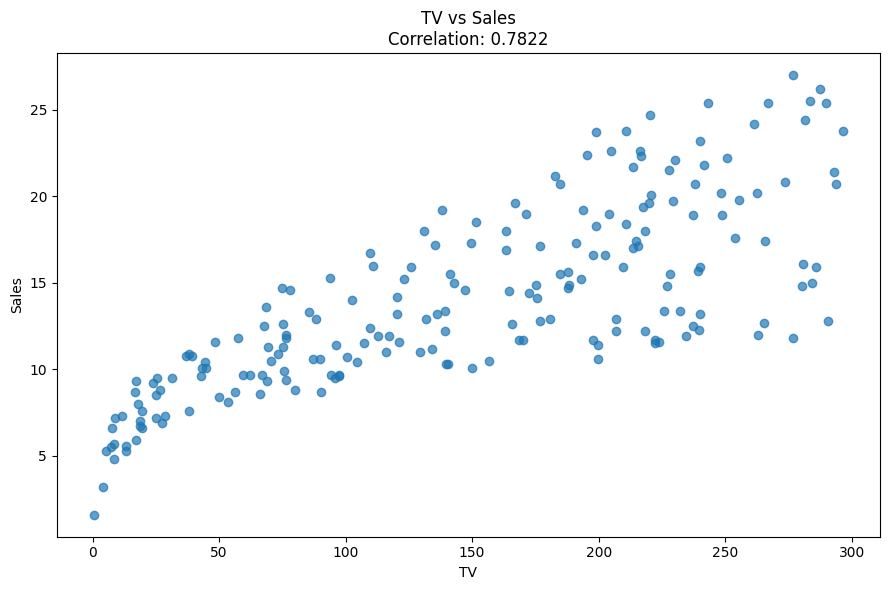

In [22]:
# Calculate correlation
tv_corr = df['TV'].corr(df['Sales'])

# Plot
plt.figure(figsize=(9, 6))
plt.scatter(df['TV'], df['Sales'], alpha=0.7)
plt.xlabel("TV")
plt.ylabel("Sales")
plt.title(f"TV vs Sales\nCorrelation: {tv_corr:.4f}")
plt.tight_layout()
plt.show()

---

# 6. Simple Linear Regression

Simple linear regression models the relationship between a single independent variable x and a dependent variable y by fitting a straight line:

$$\hat{y} = \beta_0 + \beta_1 x$$
- $\hat{y}$: Predicted value
- $\beta_0$: Intercept
- $\beta_1$: Slope

**Goal**: minimizing the error between actual value and prediction(SSE and MSE will be discussed later).

**Residual** :Measures the vertical error between actual and predicted values.

$$\text{Residual} = y - \hat{y}$$

**Error Metrics Comparison**

| Metric | Formula | Description | Used In |
|--------|---------|-------------|---------|
| **SSE (Sum of Squared Errors)** | $$\displaystyle \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$ | Total squared error. OLS minimizes this to find the best-fitting line. No division involved. | OLS (Closed-form) |
| **MSE (Mean Squared Error)** | $$\displaystyle \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$ | Average squared error. Gradient Descent typically minimizes MSE because it’s scaled and smoother for optimization. | Gradient Descent |

**We will calculate the most optimized coefficient by doing multiple approach:**
- Manually calculating Ordinary Least Square(OLS).(The Source code can be found under folder `spend_sale_lib`)
- Manually calculating Gradient Desent.(The Source code can be found under folder `spend_sale_lib`)
- NumPy
- Scikit-Learn

Additional Reading Resources:
- [Simple linear regression, Naomi Altman & Martin Krzywinski, Nature Methods volume 12, pages999–1000 (2015)](https://www.nature.com/articles/nmeth.3627?utm_source=chatgpt.com)
- [Simple Linear Regression: Everything You Need to Know](https://www.datacamp.com/tutorial/simple-linear-regression?utm_source=chatgpt.com)
- [Linear Regression in Machine learning](https://www.geeksforgeeks.org/ml-linear-regression/?utm_source=chatgpt.com)
- [Simple Linear Regression | An Easy Introduction & Examples](https://www.scribbr.com/statistics/simple-linear-regression/?utm_source=chatgpt.com)

### Contour and 3D plots of RSS V.S. Coefficients for Sales and TV Spends

Before diving into the process of identifying the best-fitting coefficients, it is helpful to build intuition about how the coefficients affect the Residual Sum of Squares (RSS). From the contour and 3D surface plots, we can clearly observe that RSS changes with varying values of the coefficients $\beta_0$ (Intercept) and $\beta_1$ (Slope). This visualization reinforces the fundamental objective of linear regression: **to find the optimal values of $\beta_0$ and $\beta_1$ that minimize the RSS**.

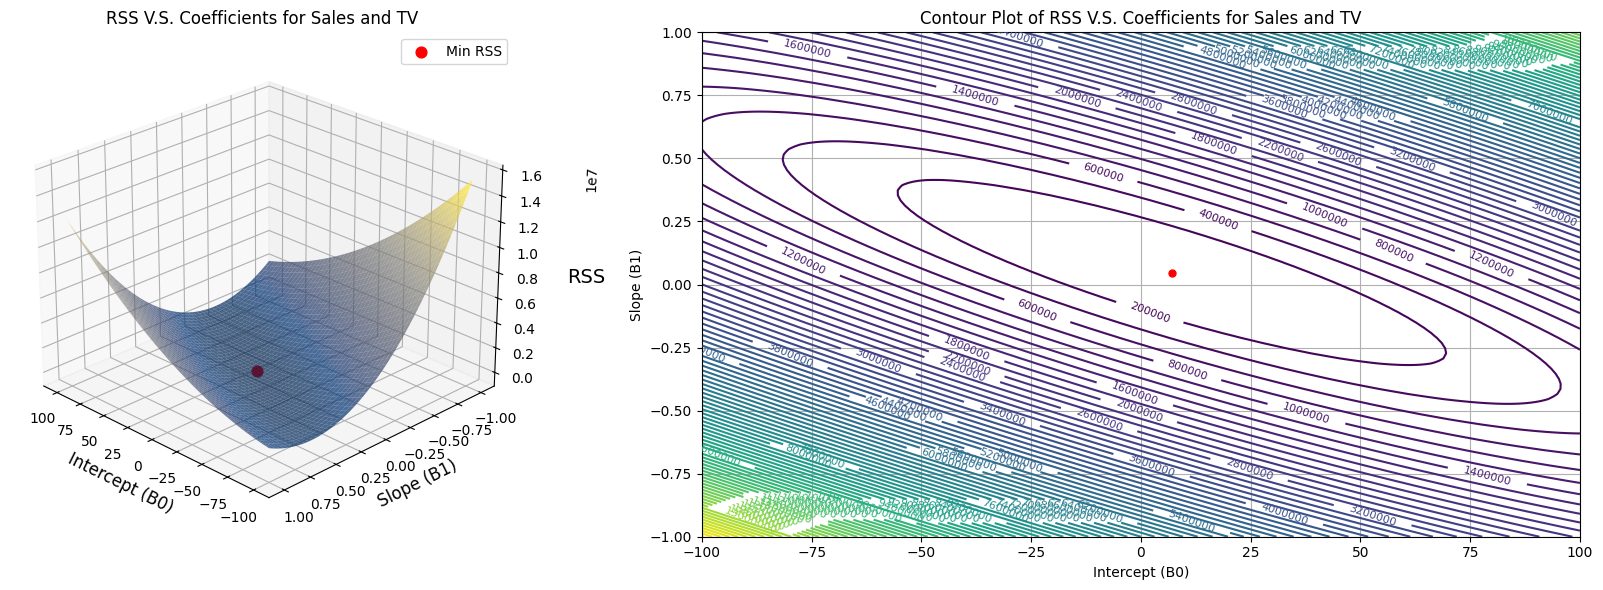

In [23]:
# Step 1: Data preparation
X = df['TV'].values
y = df['Sales'].values
n = len(y)

# Step 2: Create a parameter grid (B0: intercept, B1: slope)
B0_vals = np.linspace(-100, 100, 200)
B1_vals = np.linspace(-1, 1, 100)
B0_grid, B1_grid = np.meshgrid(B0_vals, B1_vals)

# Step 3: Compute the RSS surface over the parameter grid
RSS = np.zeros_like(B0_grid)
for i in range(B0_grid.shape[0]):
    for j in range(B0_grid.shape[1]):
        y_pred = B0_grid[i, j] + B1_grid[i, j] * X
        RSS[i, j] = np.sum((y - y_pred) ** 2)

# Step 4: Compute the optimal OLS solution (minimum RSS point)
x_mean, y_mean = np.mean(X), np.mean(y)
B1_opt = np.sum((X - x_mean) * (y - y_mean)) / np.sum((X - x_mean)**2)
B0_opt = y_mean - B1_opt * x_mean
RSS_min = np.sum((y - (B0_opt + B1_opt * X)) ** 2)

# Step 5: Plot side-by-side visualizations
fig = plt.figure(figsize=(18, 6))

# Left: 3D surface plot of RSS
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(B0_grid, B1_grid, RSS, cmap='cividis', edgecolor='none',alpha=0.7)
ax1.set_xlabel('Intercept (B0)', fontsize=12)
ax1.set_ylabel('Slope (B1)', fontsize=12)
ax1.set_zlabel('RSS', fontsize=14, labelpad=15)
ax1.view_init(elev=25, azim=135)
ax1.set_title('RSS V.S. Coefficients for Sales and TV')

# Highlight the OLS solution with a red dot
ax1.scatter(B0_opt, B1_opt, RSS_min, color='red', s=60, label='Min RSS')
ax1.legend()

# Right: Contour plot of RSS
ax2 = fig.add_subplot(1, 2, 2)
contour = ax2.contour(B0_grid, B1_grid, RSS, levels=80, cmap='viridis')
ax2.clabel(contour, inline=True, fontsize=8)
ax2.set_xlabel('Intercept (B0)')
ax2.set_ylabel('Slope (B1)')
ax2.set_title('Contour Plot of RSS V.S. Coefficients for Sales and TV')
ax2.grid(True)

# Mark the OLS minimum point in the contour plot
ax2.plot(B0_opt, B1_opt, 'ro', markersize=5)

plt.tight_layout()
plt.show()

### Ordinary Least Squares (OLS) - Manual Implementation

The detailed derivation can be found in: [theory-docs/OLS-single-variable.md](../theory-docs/OLS-single-variable.md)

**Final OLS Estimators:**

$$
\boxed{\beta_1 = \frac{\sum (x_i - \bar{x})(y_i - \bar{y})}{\sum (x_i - \bar{x})^2}}
\quad , \quad
\boxed{\beta_0 = \bar{y} - \beta_1 \bar{x}}
$$

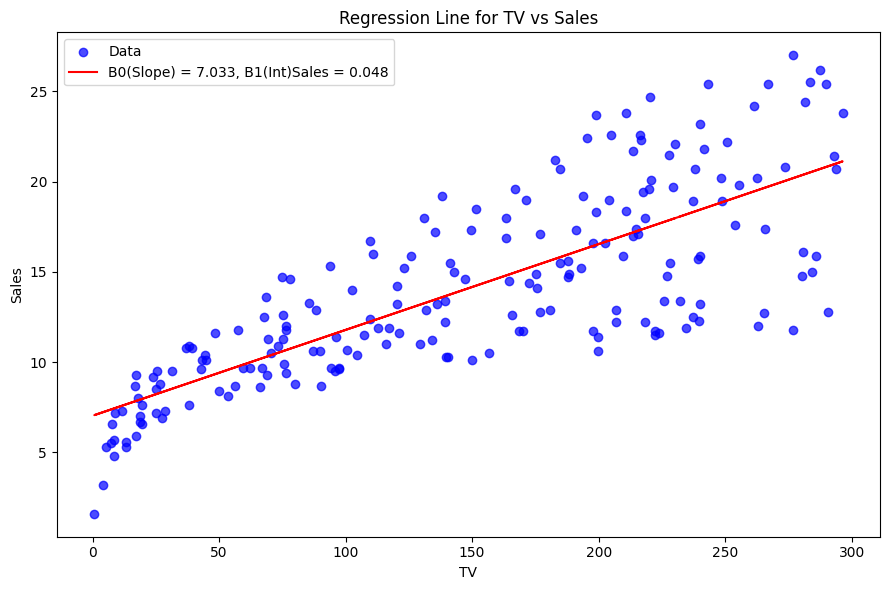

In [24]:
plt.figure(figsize=(9, 6))
feature = 'TV'
B0_slope, B1_int = Simple_OLS(df, feature, 'Sales')
plt.scatter(df[feature], df['Sales'], color='blue', label='Data', alpha=0.7)
equation_label = f"B0(Slope) = {B0_slope:.3f}, B1(Int)Sales = {B1_int:.3f}"
plt.plot(df[feature], B0_slope + B1_int * df[feature], color='red', label=equation_label)
plt.xlabel(f'{feature}')
plt.ylabel('Sales')
plt.title(f'Regression Line for {feature} vs Sales')
plt.legend()
plt.tight_layout()
plt.show()

### Gradient Descent - Manual Implementation

The following calculations are performed using the [gradient descent method](https://en.wikipedia.org/wiki/Gradient_descent). We want to minimize the cost function, typically the Mean Squared Error (MSE):

> **Disclaimer**: This discussion does not cover potential complications associated with gradient descent, including random divergence, inefficiency due to poor initialization, or instability during convergence. Key concepts are explained in detail in my [Gradient-Descent-Insights-into-Behavior-and-Optimization-Challenges](https://github.com/alextianyf/Gradient-Descent-Insights-into-Behavior-and-Optimization-Challenges) repository. For a full treatment of these foundations, please refer to that project. In this section, we’ll build on those ideas without re-deriving them here.

$$J(\beta_0, \beta_1) = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
\quad \text{where} \quad \hat{y}_i = \beta_0 + \beta_1 x_i$$

We use partial derivatives of the cost function J to update $\beta_0$ and $\beta_1$:

$$
\boxed{
\beta_0 := \beta_0 - \alpha \cdot \frac{\partial J}{\partial \beta_0}
}
\quad , \quad
\boxed{
\beta_1 := \beta_1 - \alpha \cdot \frac{\partial J}{\partial \beta_1}
}
$$

Where $\alpha$ is the learning rate.

1. Derivative w.r.t. $\beta_0$:

$$\frac{\partial J}{\partial \beta_0} = -\frac{2}{n} \sum_{i=1}^{n} (y_i - \beta_0 - \beta_1 x_i)= -\frac{2}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)$$

2. Derivative w.r.t. $\beta_1$:

$$\frac{\partial J}{\partial \beta_1} = -\frac{2}{n} \sum_{i=1}^{n} (y_i - \beta_0 - \beta_1 x_i) \cdot x_i = -\frac{2}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i) \cdot x_i$$


Feature: TV
  Optimized B0 (Intercept): 7.0176
  Optimized B1 (Slope):     0.0474


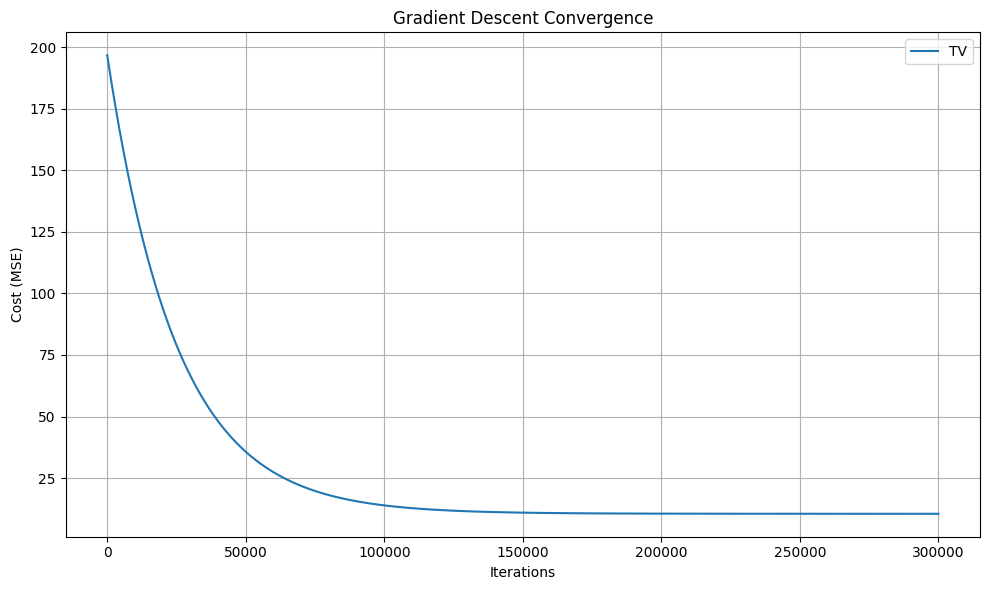

In [25]:
estimators = simple_gradient_descent(df=df, target='Sales', feature='TV',alpha=0.00001, epochs=300000,init_B0=1, init_B1=0, plot=True)

### NumPy

- You can refer to the [official documentation](https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html) to better understand the parameters and usage of numpy.polyfit.
- NumPy: Uses OLS (Ordinary Least Squares).

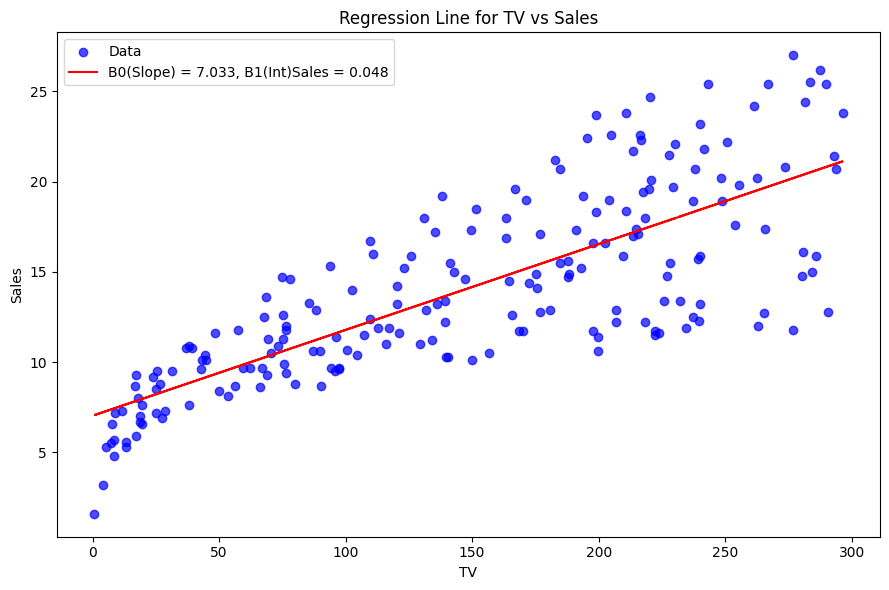

In [26]:
plt.figure(figsize=(9, 6))
y = df['Sales']
feature = 'TV'
X = df[feature]
B1, B0 = np.polyfit(X,y,deg=1) # sovling 1st degree polynomial function to find B1 and B0
plt.scatter(df[feature], df['Sales'], color='blue', label='Data', alpha=0.7)
equation_label = f"B0(Slope) = {B0:.3f}, B1(Int)Sales = {B1:.3f}"
plt.plot(df[feature], B0 + B1 * df[feature], color='red', label=equation_label)
plt.xlabel(f'{feature}')
plt.ylabel('Sales')
plt.title(f'Regression Line for {feature} vs Sales')
plt.legend()
plt.tight_layout()
plt.show()

### Scikit-Learning

- You can refer to the [official documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) to understand the parameters and usage of sklearn.linear_model.LinearRegression.
- Scikit-learn (LinearRegression): Also uses OLS (Ordinary Least Squares) by default.
- Neither of NumPy or Scikit-learn uses Gradient Descent unless you specifically use models like SGDRegressor.

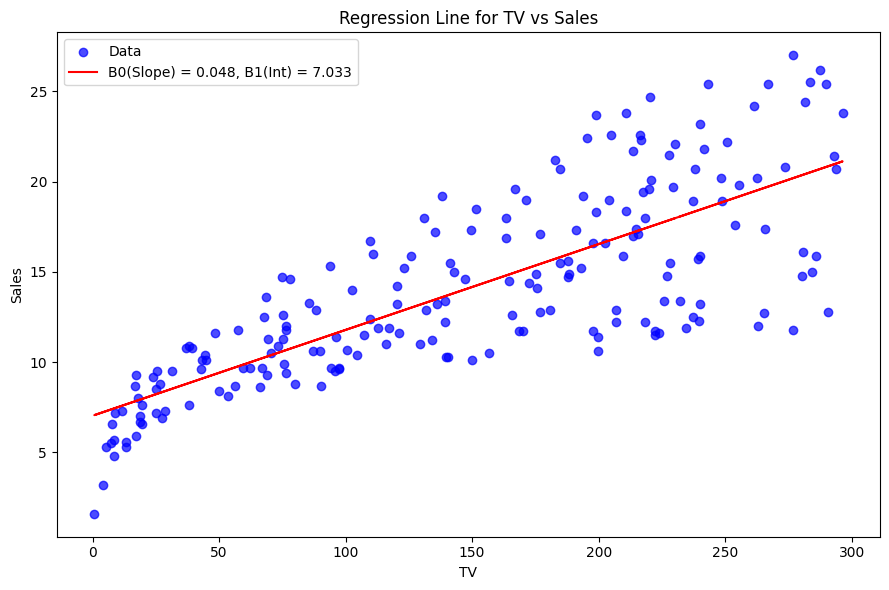

In [27]:
plt.figure(figsize=(9, 6))
y = df['Sales']
feature = 'TV'
X = df[[feature]]  # 2D shape required for sklearn
model = LinearRegression()
model.fit(X, y)

B0 = model.intercept_
B1 = model.coef_[0]

plt.scatter(df[feature], y, color='blue', label='Data', alpha=0.7)

equation_label = f"B0(Slope) = {B1:.3f}, B1(Int) = {B0:.3f}"
plt.plot(df[feature], model.predict(X), color='red', label=equation_label)

plt.xlabel(f'{feature}')
plt.ylabel('Sales')
plt.title(f'Regression Line for {feature} vs Sales')
plt.legend()
plt.tight_layout()
plt.show()

### Best Coefficient Result Interpretation

- For the provided dataset, the best-fit coefficients are:
  - **$\beta_0$ (Intercept) = 7.03**, and
  - **$\beta_1$ (Slope) = 0.0475**.
- This means that, according to the linear approximation, for every additional $1,000 spent on TV advertising, we expect an increase of approximately 47.5 units in product sales.

### A Brief Discussion of OLS vs. Gradient Descent for Linear Regression

**OLS** provides a closed-form solution to linear regression by directly solving for the coefficients that minimize the Residual Sum of Squares (RSS).

- **Pros:**
  - Exact solution with no need for iteration
  - Fast and efficient for small to medium-sized datasets
  - Easy to interpret mathematically
  - No need to tune learning rate or iterations
- **Cons:**
  - Computationally expensive for large datasets due to matrix inversion
  - May be unstable if features are highly collinear (multicollinearity)
  - Not suitable for very high-dimensional data (e.g., sparse or streaming)

**Gradient descent** is an iterative optimization algorithm that gradually updates the coefficients by following the negative gradient of the cost function.

- **Pros:**
  - Works well for large-scale datasets and high-dimensional problems
  - Memory efficient—no need to compute large matrix inverses
  - Can be used when closed-form solution doesn’t exist (e.g., non-linear models)
- **Cons:**
  - Requires learning rate tuning
  - May diverge if poorly initialized or poorly tuned
  - Convergence can be slow or oscillatory
  - Only finds a local minimum (though this is usually fine for convex problems like linear regression)

| Feature                        | Ordinary Least Squares (OLS)                                | Gradient Descent (GD)                                  |
|-------------------------------|--------------------------------------------------------------|--------------------------------------------------------|
| Solution Type                 | Closed-form (analytical)                                     | Iterative optimization                                 |
| Speed on Small Data           | Very fast                                                    | Slower due to iterations                              |
| Speed on Large Data           | Slower (matrix inversion cost)                              | Scales better with large data                         |
| Memory Usage                  | High (needs to compute matrix inverses)                     | Low (no large matrix operations)                      |
| Interpretability              | High                                                         | Moderate                                               |
| Suitability for High-Dim Data | Poor (inefficient for sparse/high-dim data)                 | Good                                                   |
| Hyperparameter Tuning         | None                                                         | Requires tuning (e.g., learning rate, epochs)         |
| Risk of Divergence            | None                                                         | Yes (if learning rate poorly chosen)                  |
| Exactness of Solution         | Exact                                                        | Approximate (converges to minimum)                    |
| Use Case Examples             | Classical regression, small/medium tabular data             | Deep learning, online learning, large-scale problems   |

<br>

---

# 7. Hypothesis Test

Hypothesis testing is a rigorous **statistical framework** for deciding whether sample data provide sufficient evidence to reject a specific claim about a population.

It involves formulating two competing hypotheses:

- **Null Hypothesis ($H_0$)** : The status-quo or “no effect” assumption that we seek to challenge.  
- **Alternative Hypothesis ($H_a$)** : The claim we hope to support—indicating the presence of an effect or difference.

Key concepts—test statistic, p-value, critical value, significance level, and one- vs. two-tailed tests—are explained in detail in my [Hypothesis Testing Studies](https://github.com/alextianyf/Hypothesis-testing-studies) repository. For a full treatment of these foundations, please refer to that project. In this section, we’ll build on those ideas without re-deriving them here.

In our case, we want to know: Does a TV advertising have a statistically significant impact on the response variable (Sales)?

Even if we observe a positive correlation and estimate a non-zero slope coefficient, we still need to perform **hypothesis testing** to confirm that the relationship is statistically significant. Here's why:

|  Point |  Reason |  Explanation / Example |
|--------|-----------|---------------------------|
| 1. Correlation is not significance | A sample may show correlation just by chance | You observe $r = 0.4$ from 5 data points. Is this real, or just coincidence? Hypothesis testing helps answer this. |
| 2. Coefficients are estimates, not guarantees | OLS gives $\hat{\beta}_1$ based on **sample data**, not the whole population | Your model gives $\hat{\beta}_1 = 0.0475$, but without testing, we don’t know if the true $\beta_1$ might still be 0. |
| 3. Statistical significance quantifies uncertainty | We compare the estimate to its **standard error** using a t-test(The [mathematical proof](../theory-docs/standard-error.ipynb) and the [differences between variance and standard deviation](../theory-docs/variance-stddev-stderr.md) can be found in the theory-docs folder.) | $t = \frac{\hat{\beta}_1}{SE(\hat{\beta}_1)}$ tells us how far the estimate is from 0 — if it's far enough, it's likely real. |
| 4. Analogy: Thermometer with error margin | A small deviation may be due to measurement error | A thermometer reads 37.2°C ± 0.5°C. Do you really have a fever? Same with $\hat{\beta}_1$ — small changes need testing. |

<br>

> **Hypothesis testing ensures that the estimated relationship is not just due to random noise or sampling error. It helps us make confident, generalizable conclusions about the population.**



We do this by testing whether the corresponding regression coefficient (like $\beta_1$) is significantly different from zero.

- If $H_0$ : $\beta_1 = 0$, it means the predictor has no linear relationship with the outcome.(No relationship)
- If $H_1$ : $\beta_1 \ne 0$, it may have a significant impact.(a relationship exists)

We use **t-statistics** and **p-values** to determine whether a regression coefficient (e.g., $\beta_1$) is **statistically significantly different from 0**.

| Step | Description |
|------|-------------|
| **1. State Hypotheses** | <ul><li>Null Hypothesis: $H_0: \beta_1 = 0$ (no effect)</li><li>Alternative Hypothesis: $H_a: \beta_1 \ne 0$ (has an effect)</li></ul> |
| **2. Compute t-statistic** | Use the formula:  <br>  $\displaystyle t = \frac{\hat{\beta}_1 - 0}{SE(\hat{\beta}_1)}$ |
| **3. Get p-value** | Use a **t-distribution** (with degrees of freedom $n - 2$) to compute the probability of observing a t-value as extreme as the one you got. |
| **4. Make decision** | <ul><li>If p-value < 0.05: Reject $H_0$ → significant predictor</li><li>If p-value ≥ 0.05: Do not reject $H_0$ → not significant</li></ul> | 

### Common Question: How Do We Get the t-Distribution for $\beta_1$ and $\beta_0$?

Under the null hypothesis, we assume that both $\beta_1 = 0$ and $\beta_0 = 0$, meaning that the predictor has no linear relationship with the outcome — in other words, **no effect**.

To understand how the t-distribution arises, imagine repeatedly drawing random samples (e.g., 80% of the dataset each time) and fitting a linear regression model to each sample. For each sample, we calculate the estimated coefficients $\hat{\beta}_1 $ and $\hat{\beta}_0$.

If the null hypothesis is true, the estimated values of $\hat{\beta}_1$ and $\hat{\beta}_0$ will vary due to sampling variability but will, on average, be centered around 0. When we standardize these estimates by dividing them by their standard errors, we obtain **t-values** that follow a **t-distribution** centered at 0. This distribution reflects the variability of coefficient estimates under the assumption that the null hypothesis is true.


Feature: TV
  B1 (Slope) = 0.0475, SE_B1 = 0.0027, t = 17.6676, p = 0.0000e+00
  B0 (Intercept) = 7.0326, SE_B0 = 0.4578, t = 15.3603, p = 0.0000e+00
  ✅ Slope is statistically significant (reject H0)


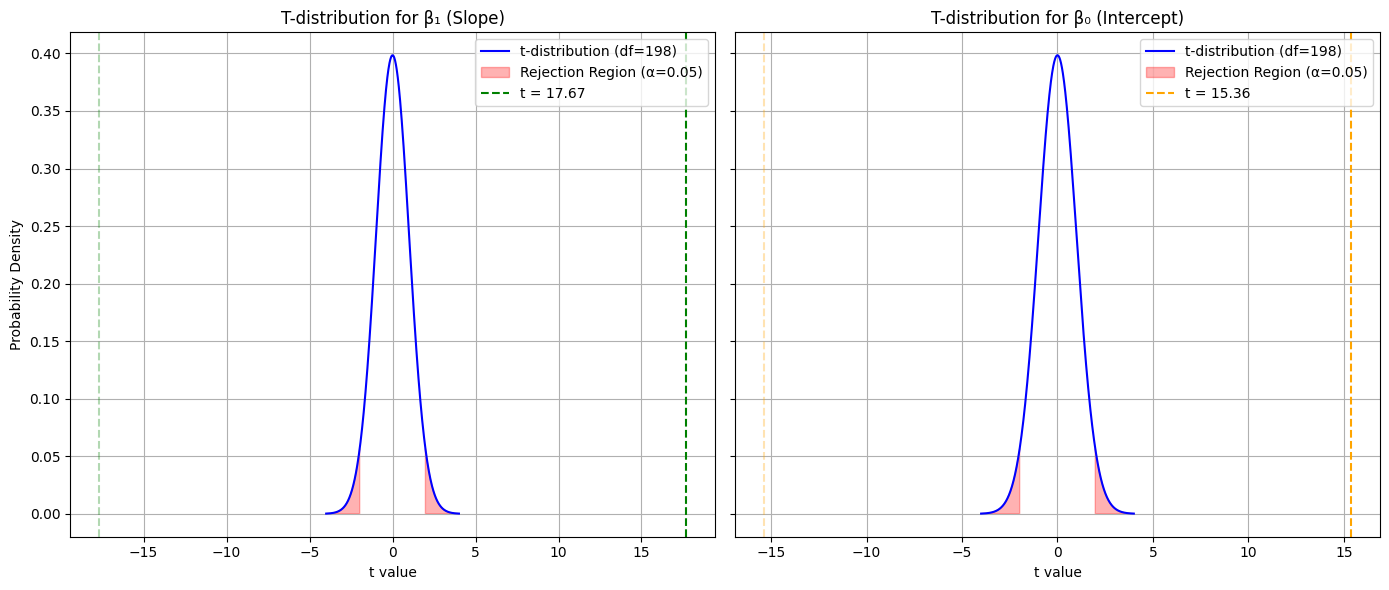

In [28]:
feature = 'TV'
y = df['Sales']
n = len(y)
dof = n - 2  # degrees of freedom

X = df[feature].values.reshape(-1, 1)

# model fitting
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

RSS = np.sum((y - y_pred) ** 2)
RSE = np.sqrt(RSS / dof)

# standard error
x_diff_sq_sum = np.sum((X - np.mean(X)) ** 2)
SE_B1 = RSE / np.sqrt(x_diff_sq_sum)
SE_B0 = RSE * np.sqrt((1 / n) + (np.mean(X) ** 2 / x_diff_sq_sum))

# t values
B1 = model.coef_[0]
B0 = model.intercept_
t_B1 = B1 / SE_B1
t_B0 = B0 / SE_B0

# p values
p_B1 = 2 * (1 - t.cdf(np.abs(t_B1), df=dof))
p_B0 = 2 * (1 - t.cdf(np.abs(t_B0), df=dof))

# print results
print(f"\nFeature: {feature}")
print(f"  B1 (Slope) = {B1:.4f}, SE_B1 = {SE_B1:.4f}, t = {t_B1:.4f}, p = {p_B1:.4e}")
print(f"  B0 (Intercept) = {B0:.4f}, SE_B0 = {SE_B0:.4f}, t = {t_B0:.4f}, p = {p_B0:.4e}")

if p_B1 < 0.05:
    print("  ✅ Slope is statistically significant (reject H0)")
else:
    print("  ❌ Slope is NOT statistically significant (fail to reject H0)")

# x range and t-distribution
x = np.linspace(-4, 4, 500)
y_pdf = t.pdf(x, df=dof)
alpha = 0.05
t_crit = t.ppf(1 - alpha / 2, df=dof)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# --- Plot for β₁ (slope) ---
axes[0].plot(x, y_pdf, label=f't-distribution (df={dof})', color='blue')
axes[0].fill_between(x, y_pdf, where=(x <= -t_crit) | (x >= t_crit), color='red', alpha=0.3, label='Rejection Region (α=0.05)')
axes[0].axvline(t_B1, color='green', linestyle='--', label=f't = {t_B1:.2f}')
axes[0].axvline(-t_B1, color='green', linestyle='--', alpha=0.3)
axes[0].set_title("T-distribution for β₁ (Slope)")
axes[0].set_xlabel("t value")
axes[0].set_ylabel("Probability Density")
axes[0].legend()
axes[0].grid(True)

# --- Plot for β₀ (intercept) ---
axes[1].plot(x, y_pdf, label=f't-distribution (df={dof})', color='blue')
axes[1].fill_between(x, y_pdf, where=(x <= -t_crit) | (x >= t_crit), color='red', alpha=0.3, label='Rejection Region (α=0.05)')
axes[1].axvline(t_B0, color='orange', linestyle='--', label=f't = {t_B0:.2f}')
axes[1].axvline(-t_B0, color='orange', linestyle='--', alpha=0.3)
axes[1].set_title("T-distribution for β₀ (Intercept)")
axes[1].set_xlabel("t value")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

### t-statistic and p-value Interpretation

| Term       | Estimate | Std. Error | t-value  | p-value   |
|------------|----------|------------|----------|-----------|
| Intercept  | 7.0326   | 0.4578     | 15.3603  | < 0.001   |
| TV (Slope) | 0.0475   | 0.0027     | 17.6676  | < 0.001   |

- Intercept (β₀ = 7.0326)
  - When TV advertising spend is 0, the model predicts average sales of approximately 7030 units.
  - The intercept is statistically significant (p < 0.001), indicating it’s not due to random chance.
- Slope for TV (β₁ = 0.0475)
  - For every $1000 increase in TV advertising spend, Sales increase by approximately 47.5 units, on average.
  - The t-value of 17.67 and p < 0.001 indicate a strong statistically significant positive relationship between TV spend and Sales.
  - In other words, TV advertising has a meaningful and reliable positive effect on sales.

**Conclusion:**

- There is strong evidence to reject the null hypothesis ($H_0: \beta_1 = 0$).
- The TV advertising variable has a statistically significant and positive impact on Sales.
- This suggests that investing more in TV advertising is likely to lead to higher sales, based on the observed data.

# 8. Evaluate Coefficient Accuracy and Confidence Interval

### Confidence Interval

> **Disclaimer**: In this project, we will not delve into the various properties of confidence intervals, since they are explained in detail in my [Confidence Interval Studies](https://github.com/alextianyf/Confidence-interval-studies) repository.Instead, we will focus exclusively on the most commonly used case — the 95% confidence interval — which is sufficient for most simple linear regression tasks.

A 95% confidence interval has the following interpretation:
- If we were to repeatedly take samples and compute the confidence interval for each sample, approximately 95% of those intervals would contain the true (but unknown) value of the parameter.
- In the context of simple linear regression, we are often interested in constructing 95% confidence intervals for the regression coefficients $\beta_0$ (intercept) and $\beta_1$ (slope).

$$\hat{\beta_0} \pm 2 \cdot SE(\hat{\beta_0})$$

$$\hat{\beta_1} \pm 2 \cdot SE(\hat{\beta_1})$$

This means there is approximately a 95% chance that the interval

$$[\hat{\beta_0} - 2 \cdot SE(\hat{\beta_0}),\ \hat{\beta_0} + 2 \cdot SE(\hat{\beta_0})]$$

$$[\hat{\beta_1} - 2 \cdot SE(\hat{\beta_1}),\ \hat{\beta_1} + 2 \cdot SE(\hat{\beta_1})]$$

will contain the true value of $\beta_0$ or $\beta_1$, respectively.

> Note: The “2” is an approximation based on the normal distribution and is commonly used when sample size is sufficiently large. For small samples, a t-distribution should be used with appropriate degrees of freedom.

<div align="center">
  <img src="https://www.appinio.com/hs-fs/hubfs/Confidence%20Interval%20Appinio.png?width=1024&height=768&name=Confidence%20Interval%20Appinio.png" alt="IQR" width="700" height="500"/>
</div>

<div align="center">
  <img src="https://cdn.mathblog.com/wp-content/uploads/2023/11/95-percent-confidence-interval.jpg" alt="IQR" width="700" height="400"/>
</div>

Here are some good resources to read and learn about confidence interval:
- [Using the confidence interval confidently, Avijit Hazra](https://pmc.ncbi.nlm.nih.gov/articles/PMC5723800/)
- [Confidence interval Wikipedia](https://en.wikipedia.org/wiki/Confidence_interval?utm_source=chatgpt.com)

In [29]:
feature = 'TV'
x = df[feature]
y = df['Sales']
x_mean = x.mean()
y_mean = y.mean()

x_diff = x - x_mean
y_diff = y - y_mean

B1 = (x_diff * y_diff).sum() / (x_diff ** 2).sum()
B0 = y_mean - B1 * x_mean

# Prediction and residuals
y_pred = B1 * x + B0
residuals = y - y_pred
n = len(df)

RSS = (residuals ** 2).sum()
RSE = np.sqrt(RSS / (n - 2))

SE_B1 = RSE / np.sqrt((x_diff ** 2).sum())
SE_B0 = RSE * np.sqrt((1 / n) + (x_mean ** 2 / (x_diff ** 2).sum()))

# Confidence Interval（about 95%）
B1_low, B1_high = B1 - 2 * SE_B1, B1 + 2 * SE_B1
B0_low, B0_high = B0 - 2 * SE_B0, B0 + 2 * SE_B0

print(f"\nFeature: {feature}")
print(f"  Slope (B1): {B1:.4f}, Intercept (B0): {B0:.4f}")
print(f"  SE of B1: {SE_B1:.4f}, SE of B0: {SE_B0:.4f}")
print(f"  B1 range: [{B1_low:.4f}, {B1_high:.4f}]")
print(f"  B0 range: [{B0_low:.4f}, {B0_high:.4f}]")


Feature: TV
  Slope (B1): 0.0475, Intercept (B0): 7.0326
  SE of B1: 0.0027, SE of B0: 0.4578
  B1 range: [0.0422, 0.0529]
  B0 range: [6.1169, 7.9483]


### Confidence Estimation Result Interpretation

- In the case of advertising data, the 95% confidence interval for $\beta_0$ is $[6.1169,7.9483]$ and $\beta_1$ is $[0.0422,0.0529]$
- We can conclude that in the absense of any advertising, sales will, on average, fall somewhere between ~6117 to ~7948 units. 
- For each $1000 increase in TV advertising, there will be an average increase in sales of between ~42 to ~53

---

# 9. Model Evaluation

Once we have rejected the null hypothesis in favor of the alternative hypothesis, it becomes important to evaluate how well the model fits the data. In linear regression, the quality of the model fit is typically assessed using two related metrics: the *residual standard error*(RSE) and the *$R^2$* statistic.

### Residual Standard Error(RSE) 

The Residual Standard Error (RSE) is considered a measure of the lack of fit of the model. It is an estimate of the standard deviation of the error term $\varepsilon$ in the linear model:

$$
\text{RSE} = \sqrt{ \frac{1}{n - 2} RSS } = \sqrt{ \frac{1}{n - 2} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 }
$$

- $y_i$: actual values
- $\hat{y}_i$: predicted values
- $n$: number of observations
- $n - 2$: degrees of freedom for simple linear regression

The result of RSE
- It tells us roughly how far the data points deviate from the regression line on average.
- Smaller RSE → better model fit.
- It is in the same unit as the response variable (e.g., dollars if your output is sales).

| Metric | Analogy              | Purpose                                      |
|--------|----------------------|----------------------------------------------|
| RSS    | Total error "energy" | Raw total deviation — not scale-adjusted     |
| RSE    | Avg. residual spread | Scale-adjusted, interpretable average error  |

We need **RSE** because **RSS alone is not standardized** — it grows with sample size and is in squared units(e.g., dollars²).  **RSE provides a normalized, interpretable measure** of model error on the same scale as the response variable, making it more useful for assessing model quality and comparing across models.

### R² Statistic

Measures the proportion of variance in y explained by the model. 

$$
R^2 = \frac{ \text{TSS - RSS} }{ \text{TSS} } = 1 - \frac{ \text{RSS} }{ \text{TSS} }
$$

Where:
- RSS = Residual Sum of Squares = $\sum (y_i - \hat{y}_i)^2$
- TSS = Total Sum of Squares = $\sum (y_i - \bar{y})^2$

Values range from 0 to 1:
- $R^2 = 0$: model explains none of the variability.
- $R^2 = 1$: model explains all the variability.

| $R^2$ Value | Interpretation                                                                 |
|----------------|----------------------------------------------------------------------------------|
| 1              | Perfect fit: the model explains **all** the variance in the response variable.   |
| 0              | No improvement over predicting the mean: the model explains **none** of the variance. |
| < 0            | Worse than the mean model: the model adds noise and fits worse than using the mean.  |

It can still be challenging to determine what is a good R² value, and in general, this is depend on the application. There are some resources that help to understand R² result and R² as well:
- [How To Interpret R-squared in Regression Analysis](https://statisticsbyjim.com/regression/interpret-r-squared-regression/)
- *Zikmund, William G. (2000). Business research methods (6th ed). Fort Worth: Harcourt College Publishers. (Page 513)*
- *Moore, D. S., Notz, W. I, & Flinger, M. A. (2013). The basic practice of statistics (6th ed.). New York, NY: W. H. Freeman and Company. Page (138).*

All the resources point to a similar conclusion that:
- if  R² value < 0.3 this value is generally considered a None or Very weak effect size,
- if R² value 0.3 < r < 0.5 this value is generally considered a weak or low effect size,
- if R² value 0.5 < r < 0.7 this value is generally considered a Moderate effect size,
- if R² value r > 0.7 this value is generally considered strong effect size

While RSE measures average prediction error, $R^2$ measures how well your model explains the variability in the data relative to a naive model that always predicts the mean.

| Metric  | Key Question Answered                                           | Interpretation                                              |
|---------|------------------------------------------------------------------|-------------------------------------------------------------|
| RSE     | “How far off, on average, are our predictions?”                | Measures average size of the residuals in response units    |
| $R^2$ | “How much better is our model compared to just predicting the mean?” | Measures proportion of variance explained by the model     |

In [30]:
y = df['Sales']
metrics_list = []
feature = 'TV'
X = df[[feature]]
model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)
B0 = model.intercept_
B1 = model.coef_[0]

n = len(y)
mse = mean_squared_error(y, y_pred)
rse = np.sqrt(mse * n / (n - 2))
r2 = r2_score(y, y_pred)
metrics_list.append((feature, rse, r2))

# 打印每个特征的 RSE 和 R²
print("Quantity    Value")
print(f"RSE:        {rse:.3f}")
print(f"R²:         {r2:.3f}")

Quantity    Value
RSE:        3.259
R²:         0.612


### RSE and R² Result Interpretation

| Quantity | Value  |
|----------|--------|
| RSE      | 3.259  |
| $R^2$ | 0.612  |

- Actual sales in the market deviate from the true regression line by ~3260 Units, on average.
- If coefficient(B0 & B1) are accurate, the prediction of sales on the basis of TV advertising would still be off ~3260 units.
- Whether or not ~3260 units is an acceptable prediction error depends on the problem context.
- The average value of sales is around 14,000 units, and so the percentage error is 3260/14000 = **23%**.
- About **61.2%** of the variation in the response variable is explained by the model. This indicates a **moderate to strong** linear relationship between the predictor and the response. The remaining **38.8%** of the variance is due to factors not captured by the model. The model has a **reasonably good fit**, capturing over 60% of the variability.

---

# 10. Conclusion

### Summary of Findings

Based on our analysis using Simple Linear Regression, we have established a **statistically significant and quantitatively meaningful relationship between TV advertising spend and product sales**.

Your investment in TV advertising demonstrates a clear and measurable impact on sales. This model confirms that increasing your TV budget is likely to yield higher revenue — and we can now quantify that impact, enabling more informed decisions around budget planning, ROI estimation, and strategic forecasting.

- In the **absence of any advertising**, the model estimates that average sales would fall between approximately **6,117 and 7,948 units**.
- **TV advertising is a strong predictor of sales**. For every additional **$1,000** spent on TV advertising, sales are expected to increase by approximately **42 to 53 units**, on average. This relationship is not only positive but also statistically significant, with a **very low p-value (< 0.001)**, providing high confidence that the effect is real and not due to chance.
- The **coefficient of determination** \( R^2 = 0.612 \) indicates that **61.2%** of the variation in sales can be explained by changes in TV advertising alone — a **moderate to strong model fit** in real-world marketing analytics.
- The **residual standard error (RSE)** is **3.259**, suggesting that our predictions deviate from actual sales values by approximately **3,260 units** on average. The **percentage error is around 23%**, representing a reasonable level of accuracy for business forecasting.

This model offers a reliable, evidence-based link between TV advertising spend and sales performance. It can serve as a practical forecasting tool and a solid foundation for broader media mix modeling. With further refinement and integration of additional data sources, this model can evolve into a robust decision-support system for your marketing team.

### Key Business Questions and Answers

**Q1: How does TV advertising affect product sales?**  
A: There is a clear positive linear relationship — increasing TV spend leads to higher sales.

**Q2: Can we quantify the return on every additional dollar spent on TV?**  
A: Yes. Each additional $1,000 spent is associated with an average sales increase of **42 to 53 units**, based on the confidence interval of the model's slope.

**Q3: Is the relationship between TV spend and sales statistically significant?**  
A: Yes. The p-value for the slope is less than 0.001, confirming strong statistical significance.

**Q4: How accurate is our model in predicting future sales?**  
A: The model has an RSE of **3.259**, which corresponds to a **23% prediction error**—reasonably accurate for a single-variable model.

**Q5: To what extent can we rely on TV advertising alone for sales forecasting?**  
A: TV spend accounts for **61.2% of the variation** in sales. While impactful, it should ideally be combined with other predictors for better precision.

**Q6: What is the expected sales level if no advertising budget is allocated?**  
A: Sales are expected to fall between **6,117 and 7,948 units** without any TV advertising, as estimated by the model intercept’s confidence interval.

### Model Limitations

Despite the model’s demonstrated value, it is important to recognize its limitations:

- The model considers only one predictor (TV advertising), excluding other potentially influential factors such as radio, newspaper, digital channels, seasonality, or regional variations.
- It relies on assumptions of linearity and homoscedasticity, which were not exhaustively tested in this project.

### Strategic Recommendations Based on Findings

#### 1. Prioritize and Optimize TV Advertising Budget

**Why:** TV spend alone explains over 60% of the variation in sales — a substantial share for a single marketing channel.

**Action:**
- Consider increasing your TV advertising budget, particularly in campaigns where ROI can be tracked.
- Use the estimated return (**42 to 53 units per $1,000 spent**) to forecast the marginal impact of increased investment.
- Conduct A/B tests across regions or time periods to validate performance consistency.

#### 2. Adopt Forecasting for Sales Planning

**Why:** The model provides predictive insights into how future advertising decisions could affect sales.

**Action:**
- Integrate the model into your quarterly or annual sales planning process.
- Simulate multiple TV budget scenarios to identify cost-effective spending levels for meeting revenue targets.
- Set realistic, data-informed sales goals aligned with planned advertising investments.

#### 3. Investigate Diminishing Returns or Saturation Points

**Why:** Although the model assumes a linear relationship, returns on advertising may taper at higher budget levels.

**Action:**
- Conduct follow-up studies to test for nonlinear effects (e.g., diminishing returns).
- Consider segmented or piecewise regression to determine the optimal advertising spend that maximizes ROI.

### Future Work

The results strongly support a **positive linear relationship between TV advertising and product sales**. While this model is not exhaustive, it offers a robust foundation for forecasting and marketing strategy development.

To improve forecasting precision, we recommend extending this analysis using **multiple regression models** that incorporate additional variables (e.g., Radio, Online, or Seasonal Promotions). Further, exploring **nonlinear models or regularization techniques** will help capture more complex relationships and improve model generalizability in diverse market contexts.